Basic things:

In [436]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Here we create Downloader:

In [445]:
#number of pages to scrape

pages = 10

class Downloader:
    def __init__(self, link):
        self.link = link
        self.uClient = uReq(link)
        self.page_html = self.uClient.read()
        self.uClient.close()
        self.soup = BeautifulSoup(self.page_html, "lxml")
    
    def get_titles(self):
        td = self.soup.findAll('span', {"class":"title"})
        titles = []
        for ind in td:
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
            titles.append(str(ind).lstrip('<span class="title">').rstrip('span>').rstrip('</'))
        return titles
    
    def get_release_dates(self):

        td = self.soup.findAll('div', {"class":"col search_released responsive_secondrow"})
        release_dates = []
        for ind in td:
            if ind.text != "":
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
                release_dates.append(str(ind).rstrip('</div>').split(">")[-1])
            else:
                release_dates.append(None)
        return release_dates
    
    def reviews(self):
   
        td = self.soup.findAll('span', {"class":"search_review_summary positive"})
        reviews = []
        for ind in td:
            # lstrip and rstrip remove symbols from sides, strip removes white spaces
            reviews.append(str(ind).split("html=")[-1])
        return reviews
     
    def get_share_positive_reviews(self):
        text = self.reviews()
        shares = []
        for percent in text:
            shares.append(percent.split("%")[0].split("br&gt;")[1])
        return shares
        
    def get_number_user_reviews(self):  
        text = self.reviews()
        numbers = []
        for number in text:
            start = number.find("of the ") + len("of the ")
            end = number.find(" user reviews")
            numbers.append(number[start:end].replace(","," "))
        return numbers
        
    def get_prices(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        prices = []
        for ind in td:
            if "888888" not in str(ind):
                prices.append(str(ind).split("\r\n")[-1].split("</div>\n</div>")[0].strip())
            else:
                start1 = str(ind).find("><strike>") + len("><strike>")
                end1 = str(ind).find("</strike>")
                prices.append(str(ind)[start1:end1])
        return prices
    
    def get_price_after_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        sales = []
        for ind in td:
            if "888888" not in str(ind):
                sales.append(None)
            else:
                sales.append(str(ind).split("br/>")[-1].split("€")[0]+"€")
        return sales
    
    def get_rate_of_sale(self):

        td = self.soup.findAll('div', {"class":"col search_price_discount_combined responsive_secondrow"} or 
                          {"class":"col search_price discounted responsive_secondrow"})
        percent = []
        for ind in td:
            if "888888" not in str(ind):
                percent.append(None)
            else:
                start = str(ind).find(">\n<span>-")+len(">\n<span>-")
                end = str(ind).find("%")
                percent.append(str(ind)[start:end]+"%")
        return percent
    
    def dataf(self):
        titles = self.get_titles()
        dates = self.get_release_dates()
        share_reviews = self.get_share_positive_reviews()
        number_reviews = self.get_number_user_reviews()
        normal_prices = self.get_prices()
        sale_price = self.get_price_after_sale()
        sale_rate = self.get_rate_of_sale()
        
        
        self.data = pd.DataFrame({
             'title': pd.Series(titles),
             'release date': pd.to_datetime(pd.Series(dates),format='%d %b, %Y'),
             'share of positive reviews (in %)': pd.Series(share_reviews),
             'total number of reviews': pd.Series(number_reviews),
             'normal price': pd.Series(normal_prices),
             'sale price if there is a sale': pd.Series(sale_price),
             'sale rate (in %)': pd.Series(sale_rate)})
        return self.data
   
    def hoarder(self):
        urls = []
        for i in range(pages):
            urls.append(self.link + f"&page={1+i}")
        return urls
    
    def download_data(self):
        urls = self.hoarder()
        Frame = pd.DataFrame()
        for url in urls:
            Frame = Frame.append(pd.DataFrame(data = Downloader(url).dataf()))
        Frame.index = range(pages*25)
        return Frame

Link for scraping:

In [446]:
link = 'https://store.steampowered.com/search/?sort_by=Reviews_DESC&os=win&filter=globaltopsellers'

The dataset from the scraper:

In [447]:
first = Downloader(link)
#first.download() # in order to explore page html in a reasonable way, one can use online javascript beautifier, available at:
# beautifier.io
df = first.download_data()
df

,title,release date,share of positive reviews (in %),total number of reviews,normal price,sale price if there is a sale,sale rate (in %)
0,Senren＊Banka,2020-02-14,99,2 786,"29,99€","26,99€",10%
1,Aseprite,2016-02-22,99,2 704,"14,99€",None,None
2,A Short Hike,2019-07-30,99,2 692,"6,59€",None,None
3,Doki Doki Literature Club Fan Pack,2017-09-22,99,1 495,"9,99€",None,None
4,rian HD,2017-05-08,99,1 221,"9,99€","4,99€",50%
...,...,...,...,...,...,...,...
245,Half-Life 2: Episode Two,2007-10-10,96,14 510,"6,59€",None,None
246,Relaxing Puzzle Box,NaT,96,14 028,"8,24€",None,None
247,"Hook, LYNE, and SiNKR",NaT,96,13 721,"6,25€",None,None
248,The Suspicious Developments Games Collection,NaT,96,13 334,"18,73€",None,None


Creating a class to summarize the dataset:

In [448]:
class Summary:
    
    def __init__(self, data):
        self.data = data
        
    def n_of_sales(self):
        number = self.data.iloc[:,6].count()
        return print(f'The number of items on sale from the first {pages} pages is {number}.')
    
    def mean_sale(self):
        sales = [int(x[:-1]) for x in df.iloc[:,6].dropna()]
        return print(f'The mean sale is {round(np.mean(sales),2)}%.')
    
    def mean_price_of_sale(self):
        new_price = np.array([x[:-1].replace(',', '.') for x in df.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x[:-1].replace(',', '.') for x in df.iloc[:,6].dropna()]).astype(float)
        old_price = new_price/(1-(discount/100))
        return print(f'The average price before sale is {round(np.mean(old_price),2)}€, with the average price after sale being {round(np.mean(new_price),2)}€.')
    
    def price_hist(self):
        new_price = np.array([x[:-1].replace(',', '.') for x in df.iloc[:,5].dropna()]).astype(float)
        discount = np.array([x[:-1].replace(',', '.') for x in df.iloc[:,6].dropna()]).astype(float)
        #old_price = new_price/(1-(discount/100)) #original prices of items on sale
        all_prices = np.array([x[:-1].replace(',', '.').replace("-","0") for x in df.iloc[:,4]]).astype(float)
        
        all_price_hist = pd.Series(all_prices).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="blue", edgecolor = "red",linewidth=3, label="All prices")
        #old_price_hist = pd.Series(old_price).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="green", edgecolor = "blue",linewidth=3, label = "Prices before discount")
        new_price_hist = pd.Series(new_price).plot(kind="hist",bins=20, alpha=0.8, figsize=(10,5),color="orange", edgecolor = "green",linewidth=3, label = "Discounted Prices")
        
        plt.legend()
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('$$$', size='x-large')
        return plt.show()
        
    def release_hist(self):
        release = df.iloc[:,1].dropna()
        release.groupby(release.dt.year).count().plot(kind="bar", width= 1,color="blue", alpha=0.8, figsize=(10,5), edgecolor = "red",linewidth=3)
        
        plt.legend()
        plt.ylabel('Frequency', size='x-large')
        plt.xlabel('Release date (Year)', size='x-large')
        return plt.show()

Data visualization:

The number of items on sale from the first 10 pages is 59.
The mean sale is 46.97%.
The average price before sale is 26.87€, with the average price after sale being 13.44€.


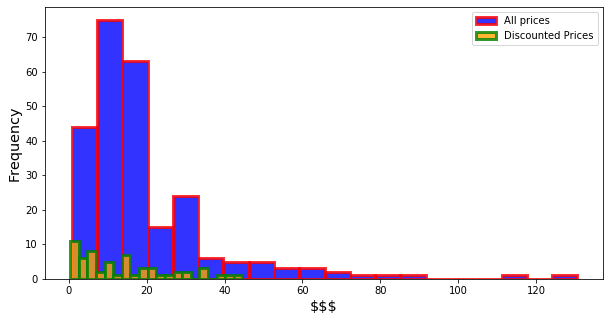

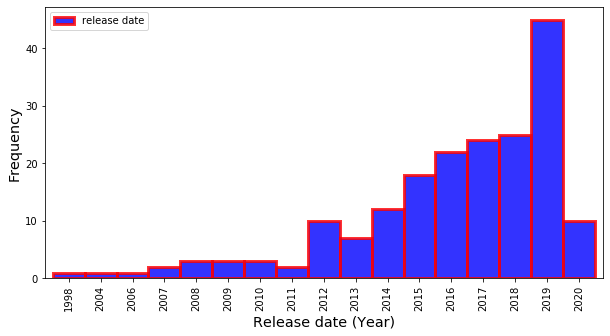

In [449]:
xx = Summary(df)
xx.n_of_sales()
xx.mean_sale()
xx.mean_price_of_sale()
xx.price_hist()
xx.release_hist()